# Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import pdb

import keras.backend as K
from keras import losses
from keras.models import Sequential, Input, Model
from keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D
from keras.utils import np_utils

# Distinguish Gaussians from Lorentzians, and predicting the mean, standard deviation if Gaussian

## Plot CNN results

In [3]:
def predict(model):
    # Make 1000 new Gaussians to apply the model to
    predX, predy = make_gaussians(1000, add_noise=True)
        
    # Apply the model to get predicted means and sigmas of the Gaussians
    pcls, preg1, preg2 = model.predict(predX, batch_size=None, verbose=0)
    
    # Check distribution of difference between true and predicted means, sigmas
    plt.subplot(511)
    _, _, _ = plt.hist(predy[:, 0] - pcls.flatten(), bins=30)
    plt.subplot(512)
    _, _, _ = plt.hist(predy[:, 1] - preg1.flatten(), bins=30)
    plt.subplot(513)
    _, _, _ = plt.hist(predy[:, 2] - preg2.flatten(), bins=30)
    
    plt.show()
    
    # Check the relation between true and predicted means, sigmas
    oto_means = np.linspace(-1., 1., 32) # one-to-one relation for means
    oto_sigmas = np.linspace(0.25, 4.0, 32) # one-to-one relation for sigmas
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 5, figsize=(15, 4))
    
    # Plot the true y's and predicted y's from the NN model
    ax1.scatter(predy[:, 0], pcls.flatten(), marker='.')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title(r'Gaussian Amplitude')

    ax2.scatter(predy[:, 1], preg1.flatten(), marker='.')
    ax2.plot(oto_means, oto_means, color='black', ls='--')
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(r'Gaussian $\mu$')
    
    ax3.scatter(predy[:, 2], preg2.flatten(), marker='.')
    ax3.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
    ax3.set_xlabel('True value')
    ax3.set_ylabel('Predicted value')
    ax3.set_title(r'Gaussian $\sigma$')

    fig.show()

## Generate distributions

### 1D Gaussian

In [4]:
# Calculate a Gaussian given its mean and standard deviation
def gaussian(x_vals, mu, sigma):
    return np.exp(-0.5 * ((x_vals - mu)/sigma)**2) / (sigma * np.sqrt(2*np.pi))

# Make array that describes Gaussian
def make_gaussians(num, mu_min=-1.0, mu_max=1.0, sig_min=0.25, sig_max=4.0, reshape=True): 

    means = np.random.uniform(mu_min, mu_max, num)
    sigmas = np.random.uniform(sig_min, sig_max, num)

    x_vals = np.linspace(-10.0, 10.0, 32)
    models = np.zeros((num, 32))

    for i in range(num):
        models[i] = gaussian(x_vals, means[i], sigmas[i])
    
    # Also want to save and return the true means, sigmas used for the Gaussians
    targets = np.vstack((means, sigmas)).T
    
    if reshape:
        models = models.reshape(num, 32, 1)

    return models, targets

### 1D Lorentzian

In [5]:
# Calculate a Lorentzian distribution given its location parameter and scale parameter
def lorentzian(x_vals, loc, scale):
    return ( 1/(np.pi*scale) ) * ( scale**2 / ((x_vals - loc)**2 + (scale)**2) )

def make_lorentzians(num, loc_min=-1.0, loc_max=1.0, scale_min=0.25, scale_max=4.0, reshape=True):
    
    locs = np.random.uniform(loc_min, loc_max, num)
    scales = np.random.uniform(scale_min, scale_max, num)
    
    x_vals = np.linspace(-10.0, 10.0, 32)
    models = np.zeros((num, 32))
    
    for i in range(num):
        models[i] = lorentzian(x_vals, locs[i], scales[i])
        
    targets = np.vstack((locs, scales)).T
    
    if reshape:
        models = models.reshape(num, 32, 1)
    
    return models, targets

#### Plot to check Lorentzian function

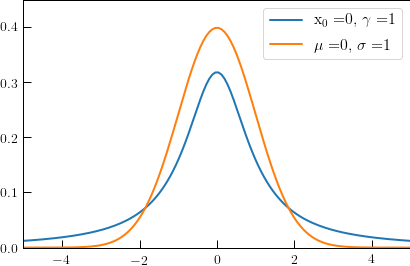

In [6]:
x_vals = np.linspace(-10.0, 10.0, 2**8)

plt.plot(x_vals, lorentzian(x_vals, 0.0, 1.0), label=r'x$_{0}=$0, $\gamma=$1')
plt.plot(x_vals, gaussian(x_vals, 0.0, 1.0), label=r'$\mu=$0, $\sigma=$1')
plt.xlim(-5, 5)
plt.ylim(0.0, 0.45)
plt.legend(fontsize=16)

plt.show()

# Separate Classification and Regression

## Generate dataset

In [7]:
# Create training and test sets
def generate_dataset(n_train=10000, n_test=1000, frac_gauss=None):
    # From desired training and test set sizes, determine the fraction that is Gaussian vs Lorentzian
    
    # Random fraction w/limits to avoid too many of any one kind
    if frac_gauss is None:
        fg_train = np.random.uniform(0.25, 0.75)
        fg_test = np.random.uniform(0.25, 0.75)
    
    # User-identified fraction
    elif frac_gauss < 1.0:
        fg_train = fg_test = frac_gauss
        
    num_gauss_train = int(fg_train * n_train)
    num_gauss_test =  int(fg_test * n_test)
    
    num_lorentz_train = n_train - num_gauss_train
    num_lorentz_test = n_test - num_gauss_test
    
    print (num_gauss_train, num_lorentz_train, num_gauss_test, num_lorentz_test)

    # Generate training and test sets
    X_train_gauss, yr_train_gauss = make_gaussians(num_gauss_train, reshape=False)
    X_test_gauss, yr_test_gauss  = make_gaussians(num_gauss_test, reshape=False)

    X_train_lorentz, yr_train_lorentz = make_lorentzians(num_lorentz_train, reshape=False)
    X_test_lorentz, yr_test_lorentz = make_lorentzians(num_lorentz_test, reshape=False)
    
    # Classification
    yc_train = np.ones(n_train)
    yc_train[0:num_gauss_train] *= 0.0 # Gaussians are 0s
    yc_train = np_utils.to_categorical(yc_train)
    
    yc_test = np.ones(n_test)
    yc_test[0:num_gauss_test] *= 0.0 # Gaussians are 0s
    yc_test = np_utils.to_categorical(yc_test)

    # Combine Gaussian and Lorentzians
    X_train = np.concatenate((X_train_gauss, X_train_lorentz))
    X_test = np.concatenate((X_test_gauss, X_test_lorentz))
    
    return X_train, yc_train, yr_train_gauss, yr_train_lorentz, X_test, yc_test, yr_test_gauss, yr_test_lorentz

## Create, compile, fit, and evaluate NN model

In [8]:
# Create dataset
X_train, yc_train, yr_tr_gauss, yr_tr_lorentz, X_test, yc_test, yr_te_gauss, yr_te_lorentz = generate_dataset()

7042 2958 635 365


### Classification model

In [9]:
# Define baseline model
def baseline_classify_model():
    # Create model

    # There are 2 classes -- Gaussian or Lorentzian -- hence the Dense(2)    
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(32, activation='relu')(inputs)
    classify = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=classify)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

### Build

In [10]:
# Build the model
class_model = baseline_classify_model()

# Fit the model
history = class_model.fit(X_train, yc_train, validation_data=(X_test, yc_test), epochs=100, batch_size=128, verbose=1)

# Final evaluation of the model
scores = class_model.evaluate(X_test, yc_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.6196 - accuracy: 0.6789 - val_loss: 0.6308 - val_accuracy: 0.6350
Epoch 2/100
10000/10000 [==============================] - 0s 11us/step - loss: 0.5635 - accuracy: 0.7042 - val_loss: 0.6115 - val_accuracy: 0.6350
Epoch 3/100
10000/10000 [==============================] - 0s 11us/step - loss: 0.5336 - accuracy: 0.7042 - val_loss: 0.5659 - val_accuracy: 0.6350
Epoch 4/100
10000/10000 [==============================] - 0s 11us/step - loss: 0.4869 - accuracy: 0.7463 - val_loss: 0.5036 - val_accuracy: 0.7320
Epoch 5/100
10000/10000 [==============================] - 0s 11us/step - loss: 0.4289 - accuracy: 0.8173 - val_loss: 0.4401 - val_accuracy: 0.7830
Epoch 6/100
10000/10000 [==============================] - 0s 12us/step - loss: 0.3704 - accuracy: 0.8569 - val_loss: 0.3730 - val_accuracy: 0.8350
Epoch 7/100
10000/10000 [==============================] - 0s 1

Epoch 56/100
10000/10000 [==============================] - 0s 10us/step - loss: 0.0063 - accuracy: 0.9991 - val_loss: 0.0065 - val_accuracy: 0.9990
Epoch 57/100
10000/10000 [==============================] - 0s 10us/step - loss: 0.0061 - accuracy: 0.9994 - val_loss: 0.0062 - val_accuracy: 0.9990
Epoch 58/100
10000/10000 [==============================] - 0s 10us/step - loss: 0.0057 - accuracy: 0.9993 - val_loss: 0.0060 - val_accuracy: 0.9990
Epoch 59/100
10000/10000 [==============================] - 0s 10us/step - loss: 0.0055 - accuracy: 0.9995 - val_loss: 0.0058 - val_accuracy: 0.9990
Epoch 60/100
10000/10000 [==============================] - 0s 10us/step - loss: 0.0053 - accuracy: 0.9994 - val_loss: 0.0055 - val_accuracy: 0.9990
Epoch 61/100
10000/10000 [==============================] - 0s 10us/step - loss: 0.0050 - accuracy: 0.9996 - val_loss: 0.0053 - val_accuracy: 0.9990
Epoch 62/100
10000/10000 [==============================] - 0s 10us/step - loss: 0.0048 - accuracy: 0.9996

In [11]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

### Results

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


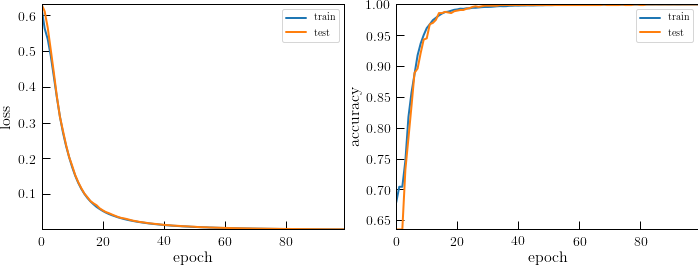

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend(['train', 'test'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['train', 'test'], loc='upper right')

fig.show()

### Regression model

In [44]:
# Check out: https://datascience.stackexchange.com/questions/28003/get-multiple-output-from-keras
# for multi-output regression using Keras NNs

def baseline_regression_model():
    # Create model
    verbose, epochs, batch_size = 1, 100, 16
    inputs = Input(shape=(X_train.shape[1],))

    x = Dense(10, activation='relu')(inputs)
    x = Dense(5, activation='relu')(x)
    
    out1 = Dense(1, activation='linear', name='mean')(x)
    out2 = Dense(1, activation='linear', name='sigma')(x)
    
    #inputs = Input(shape=(32, 1))
    #x = Conv1D(filters=16, kernel_size=3, activation='relu')(inputs)
    #x = Conv1D(filters=8, kernel_size=2, activation='relu')(x)
    #x = MaxPooling1D(pool_size=2)(x)    
    #x = Flatten()(x)
    #x = Dense(100, activation='relu')(x)
    
    out1 = Dense(1, activation='linear', name='mean')(x)
    out2 = Dense(1, activation='linear', name='sigma')(x)

    # Create model with input layer and dense layers
    model = Model(inputs=inputs, outputs=[out1, out2])
    model.compile(loss='mse', optimizer='rmsprop')
    
    return model

In [45]:
# Build the model
regr_model = baseline_regression_model()

# Fit model
regr_history = regr_model.fit(X_train[0:len(yr_tr_gauss)], [yr_tr_gauss[:,0], yr_tr_gauss[:,1]], epochs=100, verbose=1)

# Run model on test set
regr_accuracy = regr_model.evaluate(X_test[0:len(yr_te_gauss)], [yr_te_gauss[:,0], yr_te_gauss[:,1]], batch_size=16, verbose=0)

Epoch 1/100
7042/7042 [==============================] - 0s 62us/step - loss: 2.8811 - mean_loss: 0.3216 - sigma_loss: 2.5540
Epoch 2/100
7042/7042 [==============================] - 0s 48us/step - loss: 0.5090 - mean_loss: 0.2812 - sigma_loss: 0.2270
Epoch 3/100
7042/7042 [==============================] - 0s 44us/step - loss: 0.2047 - mean_loss: 0.1753 - sigma_loss: 0.0291
Epoch 4/100
7042/7042 [==============================] - 0s 43us/step - loss: 0.0863 - mean_loss: 0.0646 - sigma_loss: 0.0214
Epoch 5/100
7042/7042 [==============================] - 0s 44us/step - loss: 0.0294 - mean_loss: 0.0187 - sigma_loss: 0.0106
Epoch 6/100
7042/7042 [==============================] - 0s 45us/step - loss: 0.0099 - mean_loss: 0.0061 - sigma_loss: 0.0037
Epoch 7/100
7042/7042 [==============================] - 0s 44us/step - loss: 0.0052 - mean_loss: 0.0030 - sigma_loss: 0.0023
Epoch 8/100
7042/7042 [==============================] - 0s 47us/step - loss: 0.0037 - mean_loss: 0.0018 - sigma_loss:

7042/7042 [==============================] - 0s 42us/step - loss: 6.7152e-04 - mean_loss: 1.4172e-04 - sigma_loss: 5.2822e-04
Epoch 62/100
7042/7042 [==============================] - 0s 42us/step - loss: 6.5612e-04 - mean_loss: 1.5172e-04 - sigma_loss: 5.0330e-04
Epoch 63/100
7042/7042 [==============================] - 0s 43us/step - loss: 6.4759e-04 - mean_loss: 1.5374e-04 - sigma_loss: 4.9421e-04
Epoch 64/100
7042/7042 [==============================] - 0s 43us/step - loss: 6.4300e-04 - mean_loss: 1.4674e-04 - sigma_loss: 4.9665e-04
Epoch 65/100
7042/7042 [==============================] - 0s 42us/step - loss: 6.3692e-04 - mean_loss: 1.3605e-04 - sigma_loss: 4.9970e-04
Epoch 66/100
7042/7042 [==============================] - 0s 42us/step - loss: 6.3918e-04 - mean_loss: 1.3737e-04 - sigma_loss: 5.0092e-04
Epoch 67/100
7042/7042 [==============================] - 0s 42us/step - loss: 6.2632e-04 - mean_loss: 1.3603e-04 - sigma_loss: 5.0081e-04
Epoch 68/100
7042/7042 [================

## Test classification + regression on new data

In [46]:
# Generate the new Gaussians and Lorentzians to be used in classification and regression
#X_train, yc_train, yr_tr_gauss, yr_tr_lorentz, X_test, yc_test, yr_te_gauss, yr_te_lorentz = generate_dataset()
_, _, _, _, new_X, new_yc, new_yteg, new_ytel = generate_dataset(n_train=10, n_test=1000)

#print (new_pred_y)#, np.argmax(new_pred_y, axis=1))

6 4 429 571


In [47]:
new_yc_pred = class_model.predict(new_X)
new_classifications = np.argmax(new_yc_pred, axis=1)

gauss_idx = np.where(new_classifications == 0)[0]
print (len(gauss_idx))

new_yr_pred = regr_model.predict(new_X[gauss_idx])

429


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


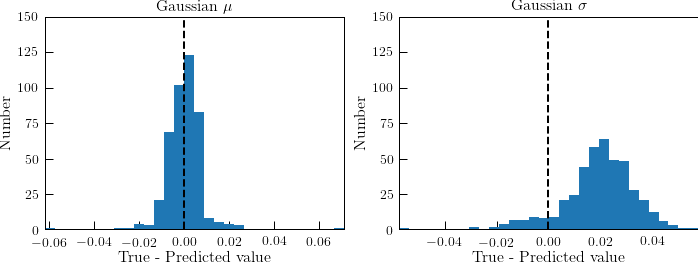

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(new_yteg[:,0] - new_yr_pred[0].flatten(), bins=30)
ax1.axvline(0.0, color='black', ls='--')
ax1.set_xlabel('True - Predicted value')
ax1.set_ylabel('Number')
ax1.set_title(r'Gaussian $\mu$')
ax1.set_ylim(0, 150)

ax2.hist(new_yteg[:,1] - new_yr_pred[1].flatten(), bins=30)
ax2.axvline(0.0, color='black', ls='--')
ax2.set_xlabel('True - Predicted value')
ax2.set_ylabel('Number')
ax2.set_title(r'Gaussian $\sigma$')
ax2.set_ylim(0, 150)

fig.show()

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


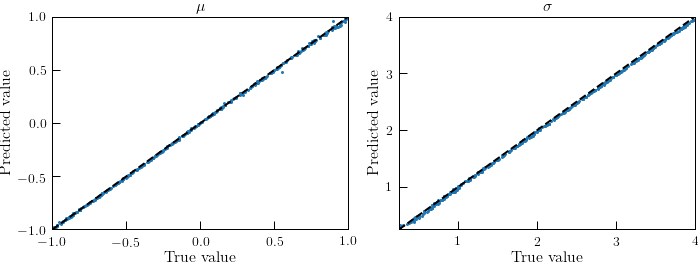

In [50]:
# Check the relation between true and predicted means, sigmas
oto_means = np.linspace(-1., 1., 32) # one-to-one relation for means
oto_sigmas = np.linspace(0.25, 4.0, 32) # one-to-one relation for sigmas

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Plot the true y's and predicted y's from the NN model
ax1.plot(new_yteg[:,0], new_yr_pred[0].flatten(), marker='.', ls='None')
# Plot the 1-to-1 line
ax1.plot(oto_means, oto_means, color='black', ls='--')
ax1.set_xlim(-1.0, 1.0)
ax1.set_ylim(-1.0, 1.0)
ax1.set_xlabel('True value')
ax1.set_ylabel('Predicted value')
ax1.set_title(r'$\mu$')

ax2.plot(new_yteg[:,1], new_yr_pred[1].flatten(), marker='.', ls='None')
ax2.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
ax2.set_xlim(0.25, 4.0)
ax2.set_ylim(0.25, 4.0)
ax2.set_xlabel('True value')
ax2.set_ylabel('Predicted value')
ax2.set_title(r'$\sigma$')

fig.show()

# Classify and Regress

Custom Keras loss function that conditionally creates a zero gradient: https://stackoverflow.com/questions/54031644/custom-keras-loss-function-that-conditionally-creates-a-zero-gradient

In [51]:
# Create training and test sets
def generate_dataset_wparams(n_train=10000, n_test=1000, frac_gauss=None):
    # From desired training and test set sizes, determine the fraction that is Gaussian vs Lorentzian
    
    # Random fraction w/limits to avoid too many of any one kind
    if frac_gauss is None:
        fg_train = np.random.uniform(0.25, 0.75)
        fg_test = np.random.uniform(0.25, 0.75)
    
    # User-identified fraction
    elif frac_gauss < 1.0:
        fg_train = fg_test = frac_gauss
        
    num_gauss_train = int(fg_train * n_train)
    num_gauss_test =  int(fg_test * n_test)
    
    num_lorentz_train = n_train - num_gauss_train
    num_lorentz_test = n_test - num_gauss_test
    
    print (num_gauss_train, num_lorentz_train, num_gauss_test, num_lorentz_test)

    # Generate training and test sets
    X_train_gauss, y_train_gauss = make_gaussians(num_gauss_train)
    X_test_gauss, y_test_gauss = make_gaussians(num_gauss_test)

    X_train_lorentz, y_train_lorentz = make_lorentzians(num_lorentz_train)
    X_test_lorentz, y_test_lorentz = make_lorentzians(num_lorentz_test)

    # Combine Gaussian and Lorentzians
    X_train = np.concatenate((X_train_gauss, X_train_lorentz))
    y_train = np.concatenate((y_train_gauss, y_train_lorentz))
    X_test = np.concatenate((X_test_gauss, X_test_lorentz))
    y_test = np.concatenate((y_test_gauss, y_test_lorentz))
    
    # Want to classify the arrays too...?
    # Classification
    class_train = np.ones(n_train)
    class_train[0:num_gauss_train] *= 0.0 # Gaussians are 0s
    #class_train = np_utils.to_categorical(class_train)
    
    class_test = np.ones(n_test)
    class_test[0:num_gauss_test] *= 0.0 # Gaussians are 0s
    #class_test = np_utils.to_categorical(class_test)    

    return X_train, y_train, X_test, y_test, class_train, class_test

In [52]:
# Create dataset
X_train, y_train, X_test, y_test, class_train, class_test = generate_dataset_wparams()

5624 4376 623 377


In [53]:
# https://stackoverflow.com/questions/54031644/custom-keras-loss-function-that-conditionally-creates-a-zero-gradient
# https://stackoverflow.com/questions/55764130/keras-custom-loss-with-one-of-the-features-used-and-a-condition
    
def custom_loss():
    def loss(y_true, y_pred):
    # Want a loss that returns loss = 0.0 if the class is a Lorentzian (value of 1)
        loss_val = losses.mean_squared_error(y_true, y_pred)
        # K.switch(condition, then expression, else expression)
        # If y_true is 0, then return a loss, else return 0.0
        
        return K.switch(K.equal(y_true, 0.), loss_val, K.zeros_like(loss_val))
    
    # Return a function
    return loss

In [71]:
#https://stackoverflow.com/questions/54847320/classification-and-regression-using-the-same-neural-network-using-keras
#https://stats.stackexchange.com/questions/77330/classify-and-regress-at-the-same-time   

# Define baseline model
def baseline_model():
    # Create model
    verbose, epochs, batch_size = 1, 100, 16
    #input_shape = X_train.shape[1]

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    x = Conv1D(filters=16, kernel_size=3, activation='relu')(inputs)
    x = Conv1D(filters=8, kernel_size=2, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)    
    
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    
    classify = Dense(1, activation='sigmoid', name='type')(x)
    regress1 = Dense(1, activation='linear', name='param1')(x)
    regress2 = Dense(1, activation='linear', name='param2')(x)
    
    # Create model with input layer and dense layers
    model = Model(inputs=inputs, outputs=[classify, regress1, regress2])
    #model.compile(loss=[custom_loss(), custom_loss(), custom_loss()], optimizer='rmsprop')
    model.compile(loss=['binary_crossentropy', 'mse', 'mse'], optimizer='rmsprop')
    
    return model

In [72]:
verbose, epochs, batch_size = 1, 200, 16

# Build the model
model = baseline_model()

# Fit the model
history = model.fit(X_train, [np.vstack(class_train), y_train[:,0], y_train[:,1]], epochs=epochs, verbose=verbose)

# Final evaluation of the model
scores = model.evaluate(X_test, [np.vstack(class_test), y_test[:,0], y_test[:,1]], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/200
10000/10000 [==============================] - 1s 130us/step - loss: 1.1883 - type_loss: 0.6466 - param1_loss: 0.1196 - param2_loss: 0.4213
Epoch 2/200
10000/10000 [==============================] - 1s 105us/step - loss: 0.5957 - type_loss: 0.5023 - param1_loss: 0.0155 - param2_loss: 0.0777
Epoch 3/200
10000/10000 [==============================] - 1s 109us/step - loss: 0.3395 - type_loss: 0.2724 - param1_loss: 0.0143 - param2_loss: 0.0527
Epoch 4/200
10000/10000 [==============================] - 1s 102us/step - loss: 0.1853 - type_loss: 0.1210 - param1_loss: 0.0169 - param2_loss: 0.0474
Epoch 5/200
10000/10000 [==============================] - 1s 103us/step - loss: 0.1209 - type_loss: 0.0615 - param1_loss: 0.0176 - param2_loss: 0.0417
Epoch 6/200
10000/10000 [==============================] - 1s 105us/step - loss: 0.0852 - type_loss: 0.0349 - param1_loss: 0.0152 - param2_loss: 0.0351
Epoch 7/200
10000/10000 [==============================] - 1s 103us/step - loss: 0.0627 

10000/10000 [==============================] - 1s 100us/step - loss: 0.0040 - type_loss: 8.3469e-06 - param1_loss: 7.6766e-04 - param2_loss: 0.0032
Epoch 53/200
10000/10000 [==============================] - 1s 102us/step - loss: 0.0040 - type_loss: 8.9855e-06 - param1_loss: 7.2220e-04 - param2_loss: 0.0033
Epoch 54/200
10000/10000 [==============================] - 1s 100us/step - loss: 0.0040 - type_loss: 5.3567e-06 - param1_loss: 7.2041e-04 - param2_loss: 0.0032
Epoch 55/200
10000/10000 [==============================] - 1s 102us/step - loss: 0.0038 - type_loss: 5.9652e-06 - param1_loss: 7.1062e-04 - param2_loss: 0.0031
Epoch 56/200
10000/10000 [==============================] - 1s 99us/step - loss: 0.0038 - type_loss: 6.0526e-06 - param1_loss: 7.2077e-04 - param2_loss: 0.0031
Epoch 57/200
10000/10000 [==============================] - 1s 99us/step - loss: 0.0036 - type_loss: 5.4040e-06 - param1_loss: 6.9231e-04 - param2_loss: 0.0029
Epoch 58/200
10000/10000 [=======================

10000/10000 [==============================] - 1s 100us/step - loss: 0.0021 - type_loss: 4.3474e-06 - param1_loss: 3.2282e-04 - param2_loss: 0.0017
Epoch 104/200
10000/10000 [==============================] - 1s 99us/step - loss: 0.0020 - type_loss: 3.9445e-06 - param1_loss: 3.3179e-04 - param2_loss: 0.0017
Epoch 105/200
10000/10000 [==============================] - 1s 99us/step - loss: 0.0020 - type_loss: 4.3466e-06 - param1_loss: 3.2398e-04 - param2_loss: 0.0017: 0s - loss: 0.0020 - type_loss: 6.1610e-06 - param1_loss: 2.9593e-04 - param2_
Epoch 106/200
10000/10000 [==============================] - 1s 100us/step - loss: 0.0020 - type_loss: 4.4604e-06 - param1_loss: 3.1707e-04 - param2_loss: 0.0017
Epoch 107/200
10000/10000 [==============================] - 1s 99us/step - loss: 0.0019 - type_loss: 3.2036e-06 - param1_loss: 3.2690e-04 - param2_loss: 0.0016
Epoch 108/200
10000/10000 [==============================] - 1s 99us/step - loss: 0.0019 - type_loss: 3.2859e-06 - param1_loss: 

10000/10000 [==============================] - 1s 102us/step - loss: 0.0013 - type_loss: 1.8894e-06 - param1_loss: 2.2604e-04 - param2_loss: 0.0011
Epoch 154/200
10000/10000 [==============================] - 1s 100us/step - loss: 0.0013 - type_loss: 1.8094e-06 - param1_loss: 2.1599e-04 - param2_loss: 0.0011
Epoch 155/200
10000/10000 [==============================] - 1s 100us/step - loss: 0.0013 - type_loss: 1.7634e-06 - param1_loss: 2.1001e-04 - param2_loss: 0.0011
Epoch 156/200
10000/10000 [==============================] - 1s 100us/step - loss: 0.0013 - type_loss: 2.0028e-06 - param1_loss: 2.1342e-04 - param2_loss: 0.0011
Epoch 157/200
10000/10000 [==============================] - 1s 99us/step - loss: 0.0013 - type_loss: 1.9672e-06 - param1_loss: 2.2265e-04 - param2_loss: 0.0011
Epoch 158/200
10000/10000 [==============================] - 1s 99us/step - loss: 0.0013 - type_loss: 1.7642e-06 - param1_loss: 2.1468e-04 - param2_loss: 0.0011
Epoch 159/200
10000/10000 [=================

In [73]:
_, _, new_X, new_y, new_ctr, new_cte = generate_dataset_wparams(n_train=10, n_test=10000, frac_gauss=0.5)
new_pred_y = model.predict(new_X)

5 5 5000 5000


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


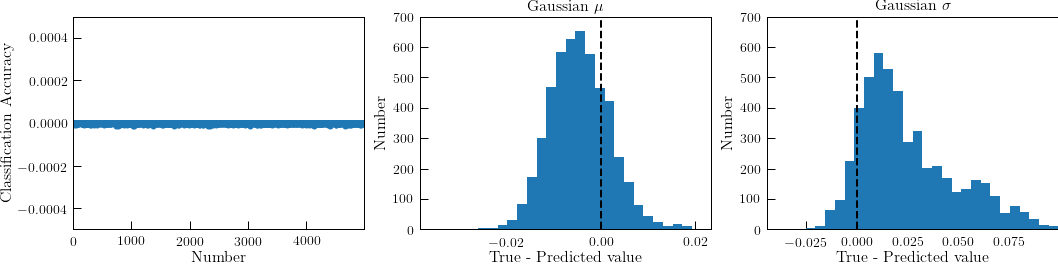

In [74]:
idx_gauss = np.where(new_pred_y[0].flatten() < 0.5)[0][-1] # All indices < this are Gaussians; > this are Lorentzian
oto_means = np.linspace(-1., 1., 32) # one-to-one relation for means
oto_sigmas = np.linspace(0.25, 4.0, 32) # one-to-one relation for sigmas

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Always 0 - some number >= 0 (i.e., always negative)
ax1.plot(new_cte[:idx_gauss] - new_pred_y[0][:idx_gauss].flatten(), marker='o', ls='None')
ax1.set_xlabel('Number')
ax1.set_ylabel('Classification Accuracy')
ax1.set_ylim(-0.0005, 0.0005)

#ax2.scatter(new_y[:,0][:idx_gauss], new_pred_y[1][:idx_gauss].flatten(), marker='.')
#ax2.plot(oto_means, oto_means, color='black', ls='--')
#ax2.set_xlabel('True value')
#ax2.set_ylabel('Predicted value')
#ax2.set_title(r'Gaussian $\mu$')

ax2.hist(new_y[:,0][:idx_gauss] - new_pred_y[1][:idx_gauss].flatten(), bins=30)
ax2.axvline(0.0, color='black', ls='--')
ax2.set_xlabel('True - Predicted value')
ax2.set_ylabel('Number')
ax2.set_title(r'Gaussian $\mu$')
ax2.set_ylim(0, 700)

#ax3.scatter(new_y[:,1][:idx_gauss], new_pred_y[2][:idx_gauss].flatten(), marker='.')
#ax3.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
#ax3.set_xlabel('True value')
#ax3.set_ylabel('Predicted value')
#ax3.set_title(r'Gaussian $\sigma$')

ax3.hist(new_y[:,1][:idx_gauss] - new_pred_y[2][:idx_gauss].flatten(), bins=30)
ax3.axvline(0.0, color='black', ls='--')
ax3.set_xlabel('True - Predicted value')
ax3.set_ylabel('Number')
ax3.set_title(r'Gaussian $\sigma$')
ax3.set_ylim(0, 700)

fig.show()

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


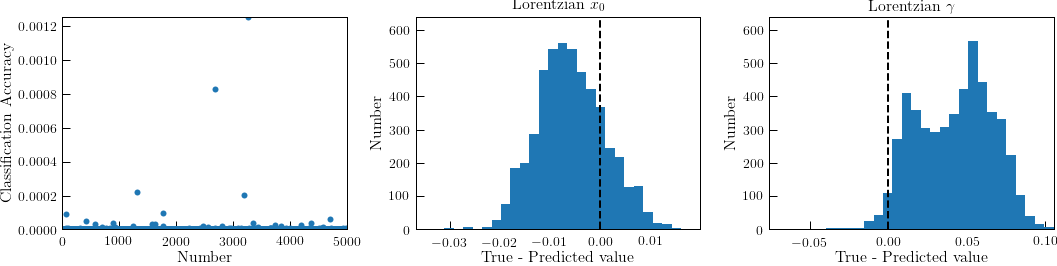

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Always 1 - some number <= 1 (i.e., always positive)
ax1.plot(new_cte[idx_gauss:] - new_pred_y[0][idx_gauss:].flatten(), marker='o', ls='None')
ax1.set_xlabel('Number')
ax1.set_ylabel('Classification Accuracy')
#ax1.set_ylim(-0.0005, 0.0005)

#ax2.scatter(new_y[:,0][idx_gauss:], new_pred_y[1][idx_gauss:].flatten(), marker='.')
#ax2.plot(oto_means, oto_means, color='black', ls='--')
#ax2.set_xlabel('True value')
#ax2.set_ylabel('Predicted value')
#ax2.set_title(r'Lorentzian $x_{0}$')

ax2.hist(new_y[:,0][idx_gauss:] - new_pred_y[1][idx_gauss:].flatten(), bins=30)
ax2.axvline(0.0, color='black', ls='--')
ax2.set_xlabel('True - Predicted value')
ax2.set_ylabel('Number')
ax2.set_title(r'Lorentzian $x_{0}$')
ax2.set_ylim(0, 640)

#ax3.scatter(new_y[:,1][idx_gauss:], new_pred_y[2][idx_gauss:].flatten(), marker='.')
#ax3.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
#ax3.set_xlabel('True value')
#ax3.set_ylabel('Predicted value')
#ax3.set_title(r'Lorentzian $\gamma$')

ax3.hist(new_y[:,1][idx_gauss:] - new_pred_y[2][idx_gauss:].flatten(), bins=30)
ax3.axvline(0.0, color='black', ls='--')
ax3.set_xlabel('True - Predicted value')
ax3.set_ylabel('Number')
ax3.set_title(r'Lorentzian $\gamma$')
ax3.set_ylim(0, 640)

fig.show()

# Following classification+regression (gender+age) problem from online

Classify and regress at the same time: https://stats.stackexchange.com/questions/77330/classify-and-regress-at-the-same-time

In [ ]:
import pandas as pd

adult = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')
adult.columns = ['age', 'workclass', 'fnlwgt', 'edu', 'edu_num', 'marital_status',
                 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                 'hours_per_week', 'native_country', 'income']
adult["sex"] = adult["sex"].astype('category').cat.codes
adult["workclass"] = adult["workclass"].astype('category').cat.codes
adult["marital_status"] = adult["marital_status"].astype('category').cat.codes
adult["race"] = adult["race"].astype('category').cat.codes
adult["occupation"] = adult["occupation"].astype('category').cat.codes
adult["native_country"] = adult["native_country"].astype('category').cat.codes

target_bin = adult[['sex']].values.astype('float32') # 0 is female?
target_num = adult[['age']].values.astype('float32')
X = adult[['workclass', 'edu_num', 'marital_status', 'occupation', 'race', 'capital_gain',
           'capital_loss', 'hours_per_week', 'native_country']].values.astype('float32')

In [ ]:
adult.head()

In [ ]:
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

inputs = Input(shape=(X.shape[1],), name='Input')

hidden = Dense(64, name='Shared-Hidden-Layer', activation='relu')(inputs)
hidden = BatchNormalization()(hidden)
out_bin = Dense(1, name='Output-Bin', activation='sigmoid')(hidden)
out_num = Dense(1, name='Output-Num', activation='linear')(hidden)

model = Model(inputs, [out_bin, out_num])
model.compile(optimizer=Adam(0.10), loss=['binary_crossentropy', 'mean_squared_error'])
model.summary()

#plot_model(model)

In [ ]:
model.fit(X, [target_bin, target_num], validation_split=.20, epochs=100, batch_size=2048)

In [ ]:
gend = model.predict(X)

In [ ]:
print ('Fraction incorrectly gendered:', 100*len(np.where(np.around(gend[0].flatten()) - target_bin.flatten() != 0.)[0]) / len(target_bin.flatten()))